In [52]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [53]:
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torchsummary import summary

In [54]:
# Custom Dataset Class for Training and Validation
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, bboxes=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        
        # Convert grayscale images to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.bboxes is not None:
            bbox = self.bboxes[idx]
            return image, label, bbox
        else:
            return image, label

In [55]:
# Custom Dataset Class for Testing
class BrainTumorTestDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        
        # Convert grayscale images to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [56]:
# Function to load data with augmentation
def load_data_with_augmentation(directory):
    images = []
    labels = []
    bboxes = []

    for tumor_type in os.listdir(directory):
        tumor_path = os.path.join(directory, tumor_type)
        if os.path.isdir(tumor_path):
            images_dir = os.path.join(tumor_path, 'images')
            labels_dir = os.path.join(tumor_path, 'labels')
            
            if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
                print(f"Images directory {images_dir} or labels directory {labels_dir} does not exist.")
                continue

            for img_file in os.listdir(images_dir):
                if img_file.endswith((".jpg", ".png")):
                    img_path = os.path.join(images_dir, img_file)
                    label_path = os.path.join(labels_dir, img_file.rsplit('.', 1)[0] + '.txt')
                    if os.path.exists(label_path):
                        with open(label_path, 'r') as f:
                            line = f.readline().strip().split()
                            if len(line) == 5:
                                label = int(line[0])
                                bbox = [float(coord) for coord in line[1:]]
                                images.append(img_path)
                                labels.append(label)
                                bboxes.append(bbox)
                            else:
                                print(f"Invalid label format in file {label_path}")
                    else:
                        print(f"Label file {label_path} does not exist for image {img_path}.")
                else:
                    print(f"Skipping file {img_file}, not an image.")
        else:
            print(f"Skipping {tumor_path}, not a directory.")
    
    print(f"Loaded {len(images)} images from {directory}")
    return images, labels, bboxes

In [57]:
# Define directories

base_dir = "../input/"
#the above directory is a path from the kaggle notebook
#actual location of the dataset in the repo is: "./dataset" -- mentioned in readme file

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')

# Load data
train_images, train_labels, train_bboxes = load_data_with_augmentation(train_dir)
val_images, val_labels, val_bboxes = load_data_with_augmentation(val_dir)

# Split training data into training and validation sets
train_images, val_images, train_labels, val_labels, train_bboxes, val_bboxes = train_test_split(
    train_images, train_labels, train_bboxes, test_size=0.2, random_state=42)

# Convert labels to numeric
label_map = {label: idx for idx, label in enumerate(np.unique(train_labels))}
reverse_label_map = {v: k for k, v in label_map.items()}
train_labels = [label_map[label] for label in train_labels]
val_labels = [label_map[label] for label in val_labels]

print(f"Training samples: {len(train_images)}, Validation samples: {len(val_images)}")

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BrainTumorDataset(train_images, train_labels, transform=train_transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Loaded 4737 images from ../input/Train
Label file ../input/Val/No Tumor/labels/image(61).txt does not exist for image ../input/Val/No Tumor/images/image(61).jpg.
Label file ../input/Val/No Tumor/labels/image(55).txt does not exist for image ../input/Val/No Tumor/images/image(55).jpg.
Invalid label format in file ../input/Val/Glioma/labels/gg (342).txt
Loaded 509 images from ../input/Val
Training samples: 3789, Validation samples: 948


Sample Training Images with Bounding Boxes:


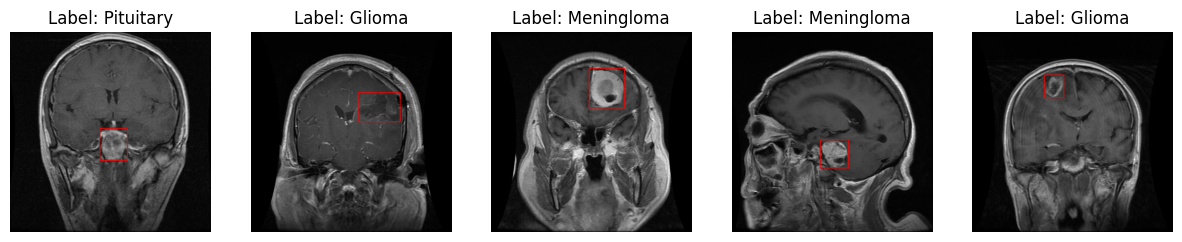

Sample Validation Images with Bounding Boxes:


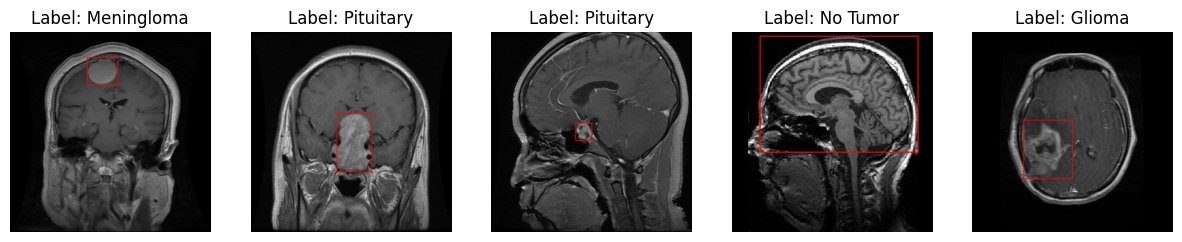

In [58]:
# Function to draw bounding box
def draw_bbox(image, bbox):
    draw = ImageDraw.Draw(image)
    width, height = image.size
    center_x, center_y, box_width, box_height = bbox
    center_x *= width
    center_y *= height
    box_width *= width
    box_height *= height
    top_left_x = int(center_x - box_width / 2)
    top_left_y = int(center_y - box_height / 2)
    bottom_right_x = int(center_x + box_width / 2)
    bottom_right_y = int(center_y + box_height / 2)
    draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], outline="red", width=2)
    return image

def show_sample_images_with_bboxes(image_paths, labels, bboxes, num_images=5, randomize=False):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    if randomize:
        indices = random.sample(range(len(image_paths)), num_images)
    else:
        indices = list(range(num_images))
    
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        label = labels[idx]
        bbox = bboxes[idx]
        image_with_bbox = draw_bbox(image, bbox)
        
        axes[i].imshow(image_with_bbox)
        labMap = {
            0: "Glioma",
            1: "Meningloma",
            2: "No Tumor",
            3: "Pituitary"
        }
        axes[i].set_title(f"Label: {labMap[label]}")
        axes[i].axis('off')
    
    plt.show()

print("Sample Training Images with Bounding Boxes:")
show_sample_images_with_bboxes(train_images, train_labels, train_bboxes)

print("Sample Validation Images with Bounding Boxes:")
show_sample_images_with_bboxes(val_images, val_labels, val_bboxes)

In [59]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Model
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

num_classes = len(label_map)
model = BrainTumorClassifier(num_classes)
model.to(device)  # Move model to GPU if available
summary(model, (3, 224, 224))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14

In [61]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

In [62]:
# Training loop with metrics tracking
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping because the loss has diminished!")
        break

Epoch 1/100, Train Loss: 0.5099638944551227, Train Accuracy: 0.8165742940089733
Validation Loss: 0.47293721673860833, Validation Accuracy: 0.8364978902953587
Epoch 2/100, Train Loss: 0.37522130821162714, Train Accuracy: 0.8730535761414622
Validation Loss: 1.4053131417383122, Validation Accuracy: 0.5358649789029536
Epoch 3/100, Train Loss: 0.27959873478719066, Train Accuracy: 0.901821060965954
Validation Loss: 1.2758275567227777, Validation Accuracy: 0.6223628691983122
Epoch 4/100, Train Loss: 0.2670033330628223, Train Accuracy: 0.9081551860649247
Validation Loss: 0.33538639809511883, Validation Accuracy: 0.8744725738396625
Epoch 5/100, Train Loss: 0.22692273290939463, Train Accuracy: 0.9245183425705991
Validation Loss: 0.24429488697635474, Validation Accuracy: 0.9187763713080169
Epoch 6/100, Train Loss: 0.19531581179389038, Train Accuracy: 0.9374505146476643
Validation Loss: 1.5700208517066536, Validation Accuracy: 0.5537974683544303
Epoch 7/100, Train Loss: 0.1855215279163739, Train A

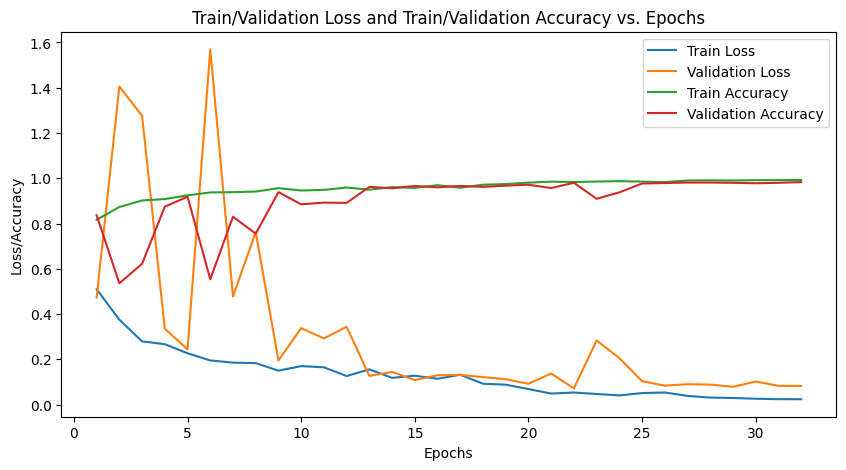

In [63]:
# Plotting training and validation metrics
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.title('Train/Validation Loss and Train/Validation Accuracy vs. Epochs')
plt.show()

Label file ../input/Val/No Tumor/labels/image(61).txt does not exist for image ../input/Val/No Tumor/images/image(61).jpg.
Label file ../input/Val/No Tumor/labels/image(55).txt does not exist for image ../input/Val/No Tumor/images/image(55).jpg.
Invalid label format in file ../input/Val/Glioma/labels/gg (342).txt
Loaded 509 images from ../input/Val
Sample Test Images with Bounding Boxes:


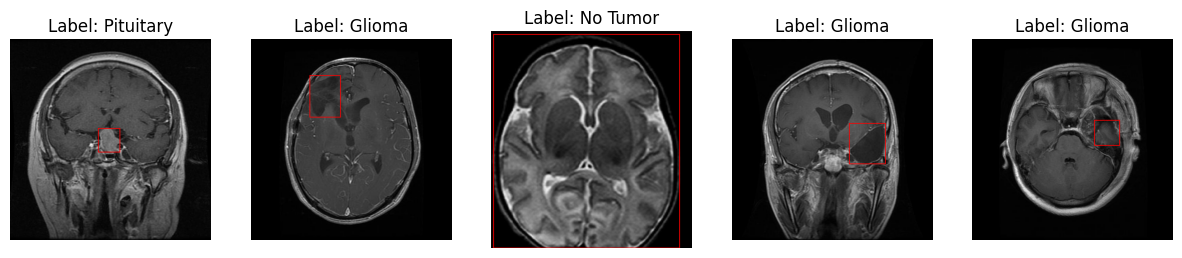

Test Loss: 0.056062927290299554, Test Accuracy: 0.9862475442043221


In [66]:
# Load test data
test_images, test_labels, test_bboxes = load_data_with_augmentation(val_dir)

# Ensure the lengths of test_images and test_labels are the same
if len(test_images) != len(test_labels):
    raise ValueError("The number of test images and labels must be the same")

# Convert test labels to numeric
test_labels = [label_map[label] for label in test_labels]

# Create test dataset and dataloader
test_dataset = BrainTumorTestDataset(test_images, test_labels, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display some test images with bounding boxes
print("Sample Test Images with Bounding Boxes:")
show_sample_images_with_bboxes(test_images, test_labels, test_bboxes, randomize=True)

# Evaluate the model on test data
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [67]:
# Save the model
torch.save(model.state_dict(), 'brain_tumor_classifier.pth')